In [19]:
#import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

In [5]:
#Reading in data
df = pd.read_csv('~/Documents/PHY_TRAIN.csv')
df.head()
df = df.drop('exampleid', axis=1)

In [69]:
#Summary statistics
#df.describe()
#df.info()
#df.isna().sum()

In [7]:
#seperating predictors and response
X = df.iloc[:, 1:] 
y = df.iloc[:, 0]

In [8]:
#Creating missing value indicator dataframe
cols = list(X.columns)
X_mvi = X[cols].isnull().astype(int).add_prefix('M_') #Creating df for MVI
X_with_mvi = pd.concat([X.fillna(X.mean()), X_mvi], axis=1) #Joining MVI df with real df and filling na values with column mean
#print (X_with_mvi)

Text(0.5, 1.05, 'Feature Correlation Matrix')

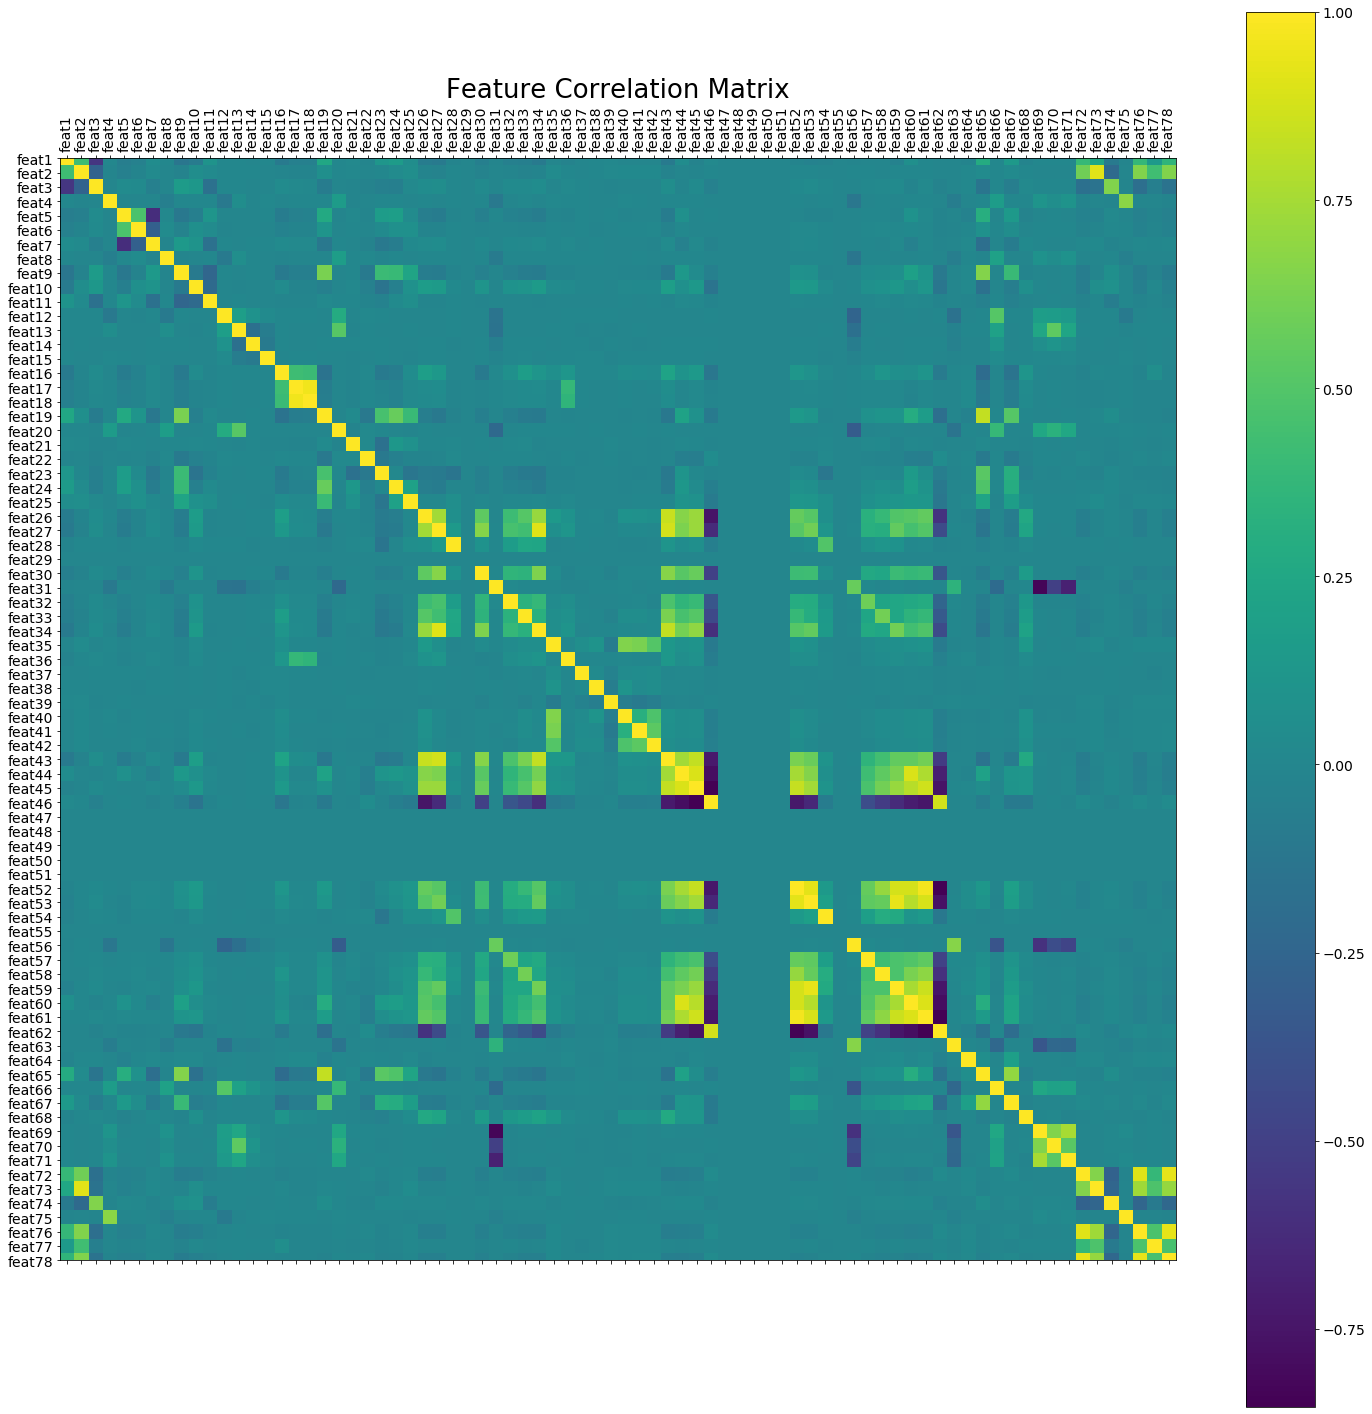

In [13]:
#Checking dataset for collinearity

X_imp = X.fillna(X.mean())
# create a correlation matrix
corr = X_imp.corr().fillna(0)
# plot the graph
fig = plt.figure(figsize=(25, 25))
plt.matshow(corr, fignum=fig.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Feature Correlation Matrix', fontsize=26)
#plt.savefig('./Documents/heatmap.png', dpi=100);

Strong collinearity is present between several variables. Some will need to be removed in order to model the data. 

In [14]:
#Found a code to caluculate VIF of all columns and remove any greater than 5. Returns DF with uncorrelated columns
#Source: https://stats.stackexchange.com/a/253620/19676

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

X_vif_red = calculate_vif_(X_imp)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


dropping 'feat61' at index: 60
dropping 'feat52' at index: 51
dropping 'feat65' at index: 62
dropping 'feat43' at index: 42
dropping 'feat44' at index: 42
dropping 'feat19' at index: 18
dropping 'feat27' at index: 25
dropping 'feat46' at index: 41
dropping 'feat53' at index: 46
dropping 'feat17' at index: 16
dropping 'feat45' at index: 39
dropping 'feat78' at index: 66
dropping 'feat9' at index: 8
dropping 'feat73' at index: 60
dropping 'feat67' at index: 54
dropping 'feat22' at index: 18
dropping 'feat34' at index: 28
dropping 'feat76' at index: 59
dropping 'feat60' at index: 47
dropping 'feat26' at index: 21
dropping 'feat69' at index: 51
Remaining variables:
Index(['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7', 'feat8',
       'feat10', 'feat11', 'feat12', 'feat13', 'feat14', 'feat15', 'feat16',
       'feat18', 'feat20', 'feat21', 'feat23', 'feat24', 'feat25', 'feat28',
       'feat29', 'feat30', 'feat31', 'feat32', 'feat33', 'feat35', 'feat36',
       'feat37', 'fe

In [65]:
#Checking correlations
X_vif_red.corr()
#X_vif_red.isna().sum()

#Nan values in correlation matrix are unexpected. Removing them.

#ONLY RUN THIS ONCE
X_vif_red = X_vif_red.drop(['feat29','feat47','feat48','feat49','feat50','feat51','feat55'], axis=1)

#print (np.linalg.det(X_vif_red)) #This having an error could be an issue

#Viewing highest correlations in data
c = X_vif_red.corr().abs()
print(c.shape)
s = c.unstack()
so = s.sort_values(kind="quicksort")
print (so[-60:-50])

LinAlgError: Last 2 dimensions of the array must be square

In [68]:
#Running Logistic regression model from stats models package on all remaining variables (VIF<5 and correlation of nan removed)
X_sm = sm.add_constant(X_vif_red)
classifier = sm.Logit(y, X_sm)
result = classifier.fit(method='newton')
print(result.summary())

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.541921
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49949
Method:                           MLE   Df Model:                           50
Date:                Sun, 19 Apr 2020   Pseudo R-squ.:                  0.2182
Time:                        17:33:30   Log-Likelihood:                -27096.
converged:                       True   LL-Null:                       -34657.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0201      0.038     -0.530      0.596      -0.094       0.054
feat1          0.0206      0.

In [17]:
#Logistic problem with LASSO
#from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(penalty='l1', solver='liblinear') #L1 penalty indicates LASSO
#classifier.fit(X_vif_red, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Logistic regression model with at least 3 two-way interaction terms

In [67]:
#Random forest modeling
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_imp, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#Gradient boosting model